# <span style="color:black; font-weight:bold;">Cross platform Mouse Brain Sample Integration Tutorial</span>
+ <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
+ <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.12.2025
+ <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.12.2025
+ <span style="color:black; font-weight:bold;">Download</span>: Cross-platform Mouse Brain Sample Integration data used in the tutorial are available at [MERFISH.h5ad](https://drive.google.com/open?id=16UYRCGe6K5FAMYhoL2-2l7B8mYeCknQq&usp=drive_fs) , [STARmapPLUS.h5ad](https://drive.google.com/open?id=12cl4ToVZ8AosPshu_NVgmwegFUlY-Ol6&usp=drive_fs) and [CosMx.h5ad](https://drive.google.com/open?id=1qQRnL-zeWmzSZSlbxOiaKVtCFDB4xUW3&usp=drive_fs)
In this tutorial we apply SpaLP to 3 Sample Integration (CosMx/STARmapPLUS/MERFISH) of the Cross-platform Mouse Brain Sample Integration dataset

<span style="color:black; font-weight:bold;">The dataset have:</span>   
+ <span style="color:black; font-weight:bold;">MERFISH</span>: 49,430 cells and 1122 genes   
+ <span style="color:black; font-weight:bold;">STARmapPLUS</span>: 43,341 cells and 1022 genes  
+ <span style="color:black; font-weight:bold;">CosMx</span>: 48,180 cells and 950 genes  
+ <span style="color:black; font-weight:bold;">After integration Total</span>: 140,951 cells and 87 genes

In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## <span style="color:black; font-weight:bold;">Loading Cross-platform Mouse Brain Sample Integration data</span>
The Cross-platform Mouse Brain Sample Integration data contains 3 spatial slices, 140,951 cells and 87 genes.

In [4]:
adata_batch1=sc.read_h5ad("/home/dbj/SpaLA/Batch/MERFISH.h5ad")
adata_batch1.obs['batch']='MERFISH'
adata_batch2=sc.read_h5ad("/home/dbj/SpaLA/Batch/STARmapPLUS.h5ad")
adata_batch2.obs['batch']='STARmapPLUS'
adata_batch3=sc.read_h5ad("/home/dbj/SpaLA/Batch/CosMx.h5ad")
adata_batch3.obs['batch']='CosMx'
adata_batch1,adata_batch2,adata_batch3

(AnnData object with n_obs × n_vars = 49430 × 1122
     obs: 'donor_id', 'brain_section_label', 'tissue', 'cell_type', 'batch'
     var: 'gene_name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
     uns: 'citation', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
     obsm: 'X_CCF', 'X_spatial_coords', 'X_umap', 'spatial',
 AnnData object with n_obs × n_vars = 43341 × 1022
     obs: 'batch'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 48180 × 950
     obs: 'x_FOV_px', 'y_FOV_px', 'x_slide_mm', 'y_slide_mm', 'propNegative', 'complexity', 'errorCtEstimate', 'percOfDataFromError', 'qcFlagsRNACounts', 'qcFlagsCellCounts', 'qcFlagsCellPropNeg', 'qcFlagsCellComplex', 'qcFlagsCellArea', 'median_negprobes', 'negprobes_quantile_0.9', 'median_RNA', 'RNA_quantile_0.9', 'nCell', 'nCount', 'nCountPerCell', 'nFeaturePerCell', 'propNegativeCellAvg', 'complexityCellAvg', 'errorCtPe

In [5]:
adata_list=[adata_batch1,adata_batch2,adata_batch3]
adata = ad.concat(adata_list, join="inner")

In [6]:
adata

AnnData object with n_obs × n_vars = 140951 × 87
    obs: 'batch'
    obsm: 'spatial'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to preprocess each platform sample separately and combine them as standard processed expression matrix.  
The standard processed expression matrix was saved in adata.obsm[<span style="color:red;">'feat'</span>] and used as input to the model.

In [7]:
adatas = []
for batch in adata.obs['batch'].unique():
    a = adata[adata.obs['batch'] == batch].copy()
    sc.pp.normalize_total(a, inplace=True)
    sc.pp.log1p(a)
    sc.pp.scale(a)
    adatas.append(a)

adata = ad.concat(adatas, join="inner")
adata.obsm['feat']=adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 10 neighbors in MERSCOPE Mouse Brain Sample Integration data. k=10  
We will compute a separate spatial neighbor index matrix for each sample and combine them as disconnected components. 

In [9]:
graphs = []
for batch in adata.obs['batch'].unique():
    a = adata[adata.obs['batch'] == batch].copy()
    graph = prepare_inputs(a, k=10, device=device)
    graphs.append(graph)

In [10]:
all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)

# 构建全局图
graph = Graph(all_features, all_neighbor_idx)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 32, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [11]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.17it/s, Epoch=199, Loss=0.9348]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed gene expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed gene expression is constructed as adata2

In [13]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding

In [14]:
adata.obsm['SpaLP']=embedding

### Reconstructed gene expression

In [15]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

## <span style="color:black; font-weight:bold;">Identify Niches and Visualization of Multi-slice Integration embedding Using UMAP</span>
We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.

In [16]:
sc.pp.neighbors(adata, use_rep='SpaLP')
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=0.5,key_added='SpaLP')

### <span style="color:black; font-weight:bold;">Multi-slice Integration embedding</span>

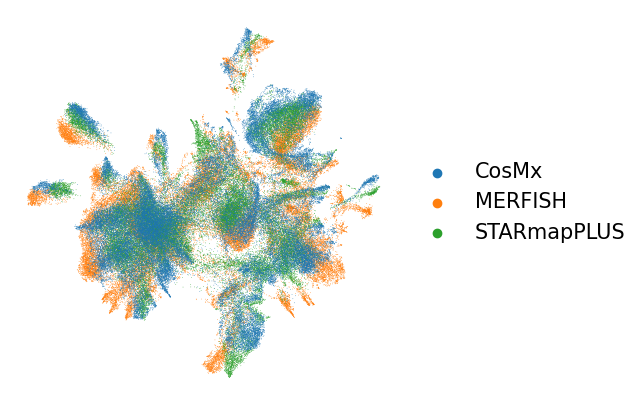

In [32]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
sc.pl.umap(adata=adata,color='batch',title='',size=1,colorbar_loc=None,frameon=False)

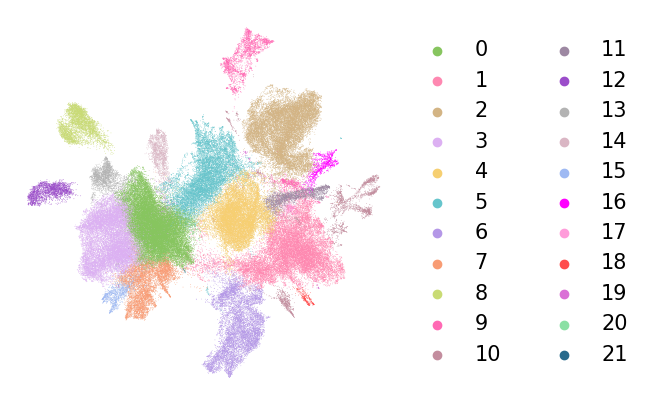

In [40]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
sc.pl.umap(adata=adata,color='SpaLP',title='',size=1,colorbar_loc=None,frameon=False,palette=latent_cluster_colors)

## <span style="color:black; font-weight:bold;">Multi-slice Niche identified by SpaLP</span>

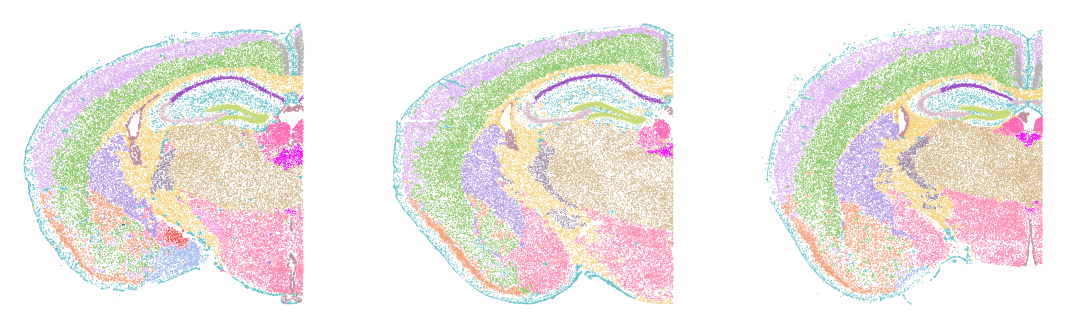

In [43]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(4.5 * len(samples), 4))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],basis='spatial',color=['SpaLP'],legend_loc=None,frameon=False,title='',palette=latent_cluster_colors,ax=axs[idx],show=False,size=2.5)

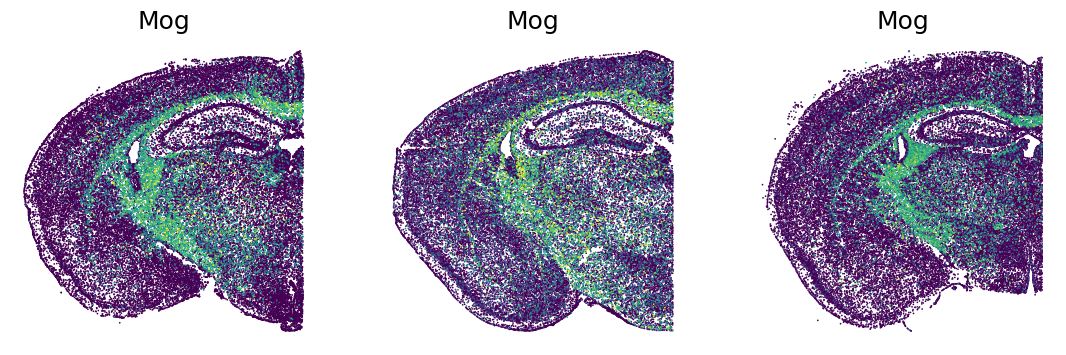

In [55]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
samples = adata2.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(4.5 * len(samples), 4))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],basis='spatial',color=['Mog'],legend_loc=None,frameon=False,colorbar_loc=None,ax=axs[idx],show=False,size=6)

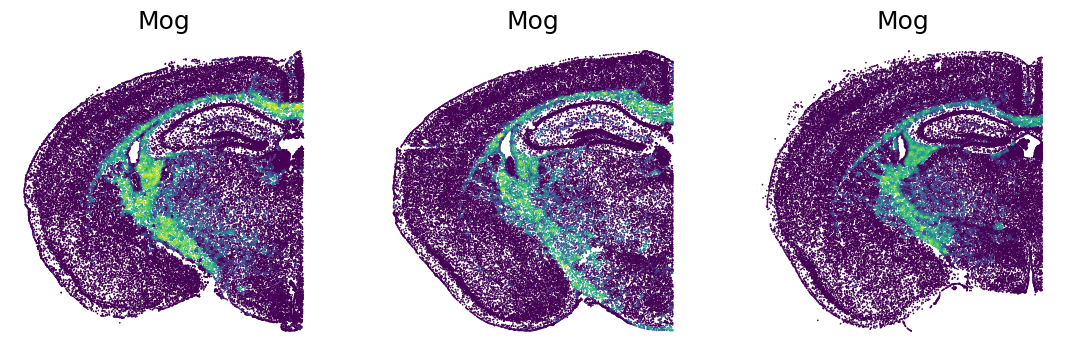

In [50]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
samples = adata2.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(4.5 * len(samples), 4))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata2[adata2.obs['batch'] == sample],basis='spatial',color=['Mog'],legend_loc=None,frameon=False,colorbar_loc=None,ax=axs[idx],show=False,size=6)